In [33]:
import numpy as np
from bnn_package import prepare_data
import matplotlib.pyplot as plt
import networkx as nx
import tqdm
# --- PATCH DE COMPATIBILITÉ (Indispensable pour Numpy récent) ---
if not hasattr(np, 'int'):
    setattr(np, 'int', int)
if not hasattr(np, 'float'):
    setattr(np, 'float', float)

from bnn_package import evolution_vec, MSD, pos_nodes_uniform, connexion_normal_deterministic, MSD_inverse, connexion_normal_random_NUMBA


In [ ]:
# --- PRÉPARATION DES DONNÉES ---
N = 1000
# Génération de X
x_raw = np.random.randn(N)
# Génération de Y (corrélé à X pour avoir une MI non nulle)
y_raw = 0.6 * x_raw + 0.3 * np.random.randn(N)

# Formatage strict
x = prepare_data(x_raw)
y = prepare_data(y_raw)

rng = np.random.default_rng(seed=42)

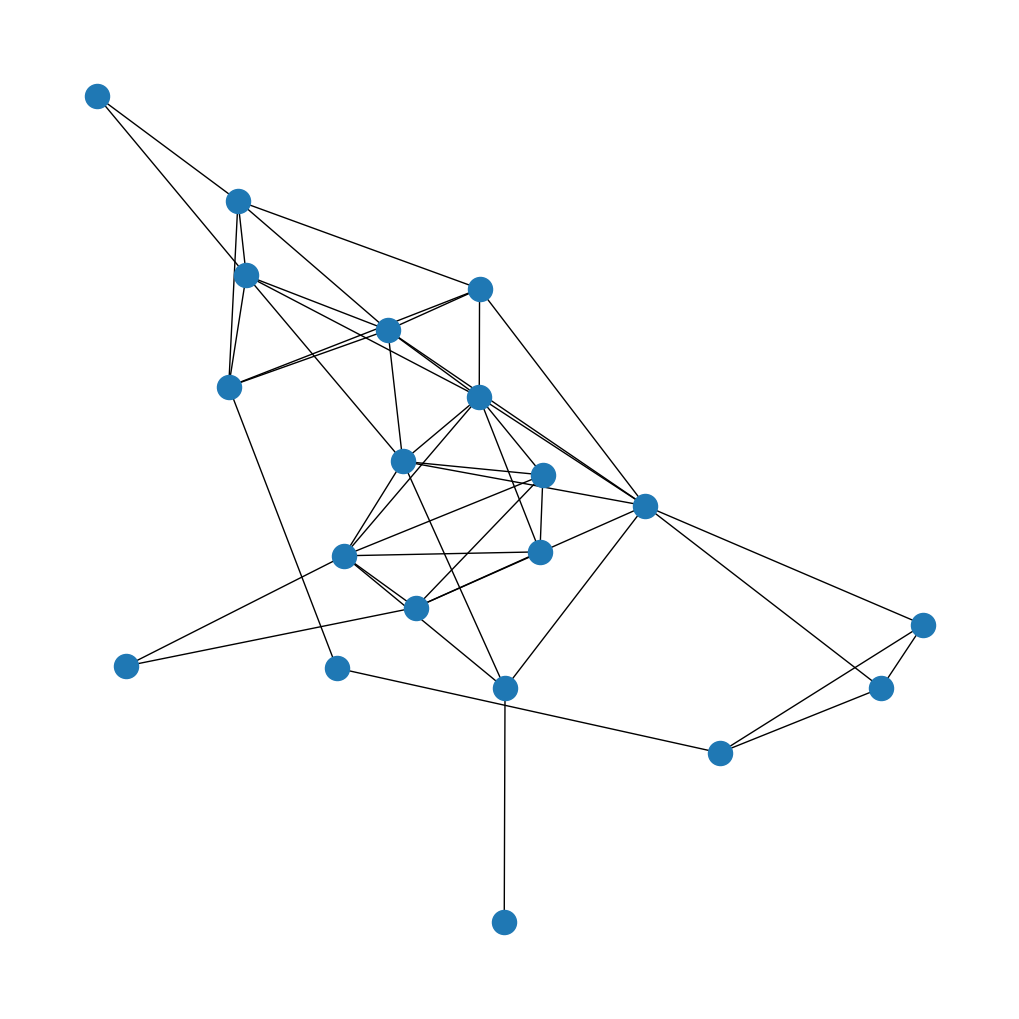

In [85]:
N = 20
std = 0.2
mean = 0.0
(xmax, ymax) = (1.0, 1.0)
test_pos = pos_nodes_uniform(N, xmax, ymax, rng)
Adja = connexion_normal_deterministic(test_pos, rng, std)
graphe = nx.from_numpy_array(Adja)
Number_Nodes=N
components = list(nx.connected_components(graphe))
representatives = [list(comp)[0] for comp in components]
for i in range(len(representatives) - 1):
    graphe.add_edge(representatives[i], representatives[i + 1])

list_ab = np.zeros((2, N))
for i in range(Number_Nodes):
    list_ab[0, i] = rng.uniform(1.1, 1.4)
    list_ab[1, i] = 0.3


Epsilon = 0.1
X_0 = [0.5 for _ in range(Number_Nodes)]
Y_0 = [0.5 for _ in range(Number_Nodes)]




plt.figure(figsize=(10, 10))
nx.draw(graphe)
plt.show()


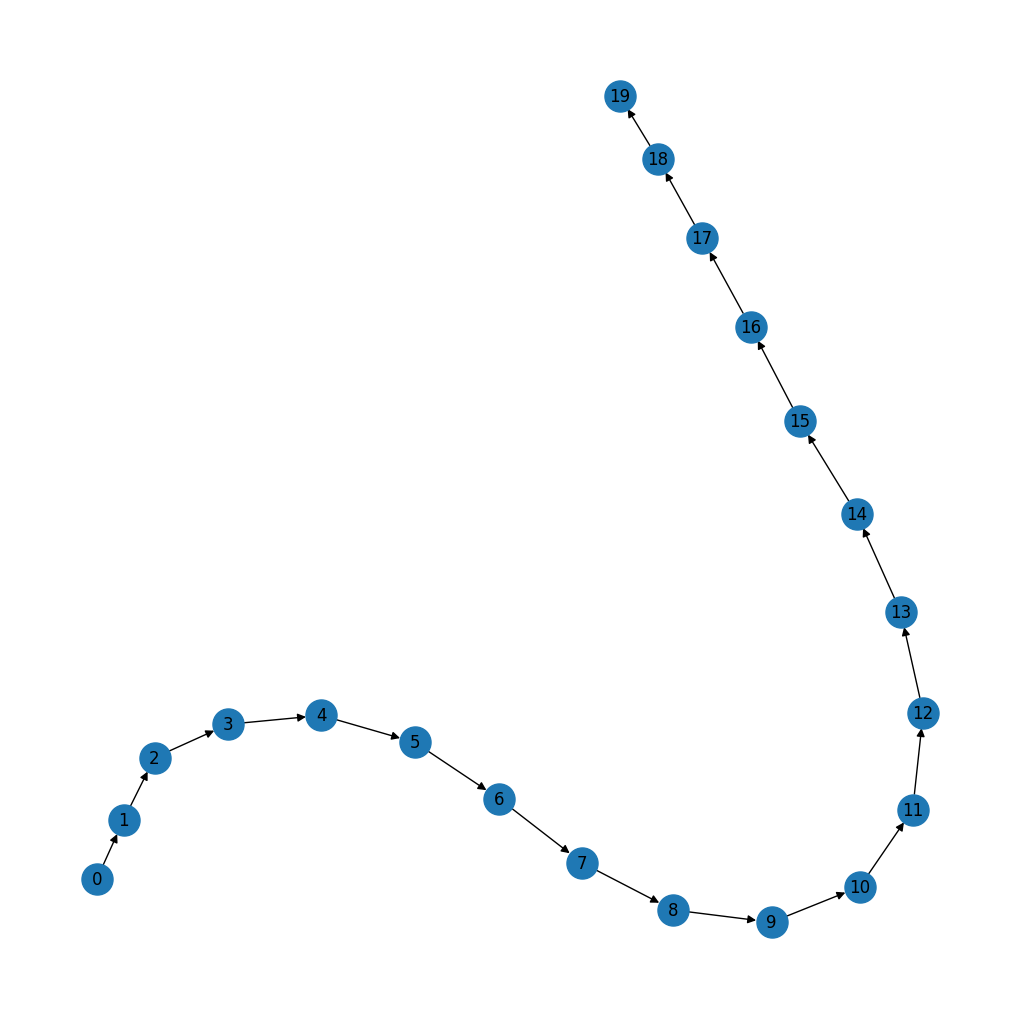

In [160]:
N = 20 
Adja = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        if i == j+1 : 
            Adja[i, j] = 1

graphe = nx.from_numpy_array(Adja)

list_ab = np.zeros((2, N))
for i in range(Number_Nodes):
    list_ab[0, i] = rng.uniform(1.1, 1.4)
    list_ab[1, i] = 0.3


Epsilon = 0.5
X_0 = [0.5 for _ in range(Number_Nodes)]
Y_0 = [0.5 for _ in range(Number_Nodes)]

plt.figure(figsize=(10, 10))
nx.draw(graphe, with_labels=True, node_size=500, arrows = True, arrowstyle='-|>', arrowsize=12)
plt.show()

In [161]:
T = 100000
transitoire = 50000
G = nx.to_numpy_array(graphe)
Xevol_forward, Yevol_forward = (
    np.zeros((len(X_0), T)),
    np.zeros((len(X_0), T)),
)


Xevol_forward, Yevol_forward = evolution_vec(
    X_0, Y_0, T, list_ab, Epsilon, G
)

print(Xevol_forward.shape, Yevol_forward.shape)




(100000, 20) (100000, 20)


In [157]:

x = prepare_data(Xevol_forward[transitoire:, 0])

y = prepare_data(Yevol_forward[transitoire:,2])

print(x.shape, y.shape)

(1, 90000) (1, 90000)


In [116]:

# -- Calcul Tranfert entropy ---
print("-" * 30)
try:
    te_result = ee.compute_TE(
        x=x,
        y=y,
        k=3,
        N_eff=-1,
        lag = 1
    )

    te = te_result[0]

    print(f"Transfert d'Entropie T(X→Y) : {te}")

except TypeError as e:
    print(f"Erreur d'arguments : {e}")
    print("Essai de secours (arguments positionnels)...")
    # Si les noms changent, on tente l'ordre standard : x, y, k, N_eff
    try:
        te = ee.compute_transfer_entropy(x, y, 3, -1)
        print(f"Transfert d'Entropie (Positionnel) : {te}")
    except Exception as e2:
        print(f"Echec total TE : {e2}")     
except Exception as e:
    print(f"Erreur TE Générale : {e}")
print("-" * 30)


------------------------------
Transfert d'Entropie T(X→Y) : 0.3429300046515187
------------------------------


TE for different lags : [0.2270943035338034, 0.2901607880051392, 0.2708583398351213, 0.25457816177278014, 0.2331053573922477, 0.2500305416028563, 0.25494511652414065, 0.22503047136867083, 0.21805392515373234, 0.2427072777635106, 0.23347371589365876, 0.20746097887159673, 0.19183681510131112, 0.23139277709784128, 0.2307838456160078, 0.1484564451617322, 0.19819930593772128, 0.2190339833279495, 0.18611240152633912, 0.15378896625999383, 0.17797029015897964, 0.21900519514132397, 0.1817107986148713, 0.17018213969813162, 0.15773229459046462, 0.21298637104613877, 0.18593775133355256, 0.1294892527944022, 0.1551338627321222, 0.19718822706259886, 0.18722656633798926, 0.10476195741896994, 0.17277706107766008, 0.19115954391317544, 0.15001670420002222, 0.1150556161131397, 0.15591943203467457, 0.1935687739840591, 0.15859155046341736, 0.14451764805092887, 0.1430792556611691, 0.18069961348918323, 0.15779465288500796, 0.11178266675880928, 0.13944083699168947, 0.18781477260872967, 0.16741327392622068, 0.0

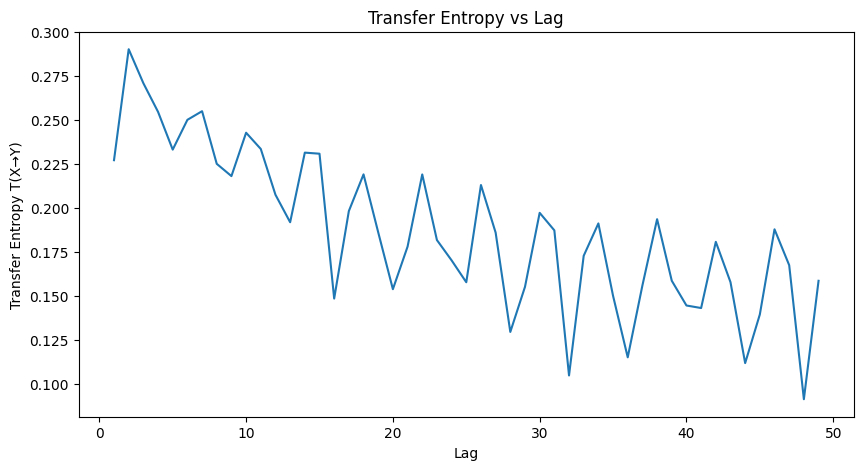

KeyboardInterrupt: 

In [ ]:
LAGS = [i for i in range(1,50)]
TE=[]
for i in LAGS:
    TE.append(ee.compute_TE(
        x=x,
        y=y,
        k=3,
        N_eff=-1,
        lag = i
    )[0])
print("TE for different lags :", TE)

print(LAGS)
TE_MAX = max(TE)
LAG_MAX = LAGS[TE.index(TE_MAX)]
print(f"Max TE {TE_MAX} for lag {LAG_MAX}")
plt.figure(figsize=(10,5))
plt.plot(LAGS,TE)
plt.xlabel("Lag")
plt.ylabel("Transfer Entropy T(X→Y)")
plt.title("Transfer Entropy vs Lag")
plt.show()

Node 5 : Max TE 0.6040224607110002 for lag 4
Node 6 : Max TE 0.6877534431764566 for lag 4
Node 7 : Max TE 0.4458994906447926 for lag 4
Node 8 : Max TE 0.17290383092095174 for lag 4
Node 9 : Max TE 0.14848692778267847 for lag 19
Node 10 : Max TE 0.0333856573111555 for lag 3
Node 11 : Max TE 0.06997732085556303 for lag 4
Node 12 : Max TE 0.10520490018783706 for lag 5
Node 13 : Max TE 0.05900517556632945 for lag 13
Node 14 : Max TE 0.0015755721904480268 for lag 16


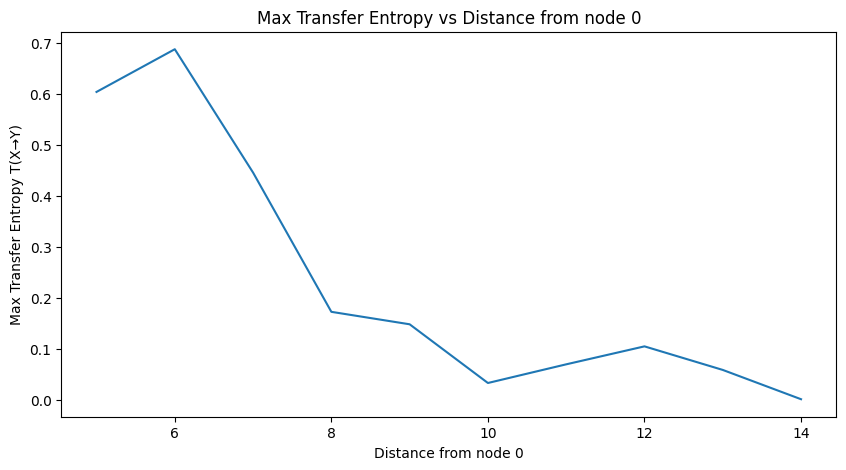

In [163]:
TES = []
distances = []
for i in range(5,N-5):
    distances.append(i)
    x = prepare_data(Xevol_forward[transitoire:,4])
    y = prepare_data(Yevol_forward[transitoire:,i])
    LAGS = [i for i in range(1,20)]
    TE=[]
    for l in LAGS:
        TE.append(ee.compute_TE(
            x=x,
            y=y,
            k=3,
            N_eff=-1,
            lag = l
            )[0])
    TE_MAX = max(TE)
    LAG_MAX = LAGS[TE.index(TE_MAX)]
    TES.append(TE_MAX)
    print(f"Node {i} : Max TE {TE_MAX} for lag {LAG_MAX}")

plt.figure(figsize=(10,5))
plt.plot(distances,TES)
plt.xlabel("Distance from node 0")
plt.ylabel("Max Transfer Entropy T(X→Y)")
plt.title("Max Transfer Entropy vs Distance from node 0")
plt.show()
    
